
# Project 1 — Parts c)–f)
This notebook solves **c, d, e, f** using the provided modules in this repo:
`data.py`, `grad.py`, `metrics.py`, `models.py`, `plots.py`, `resampling.py`, `utils.py`.


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (used in ALL notebooks) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 25      # max polynomial degree for features
P_FIXED     = 25      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
ETA_FULL = 1e-3     # full-batch GD steps (common for OLS and ridge)
ETA_FULL_OLS = 1e-3
ETA_FULL_RIDGE = 4e-3     # full-batch GD steps
ITERS_FULL = 2000     # full-batch GD iterations
LAM_RIDGE  = 30   # since n_factor=True, this gives α=0.1 (see alpha_from_lambda)
BETA = 0.3    # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)


## c) Gradient Descent for OLS and Ridge (using `grad.py`)

We first use the plain gradient descent method. We run a code to find the best eta value from a selection, the code picks the largest one that keeps the loss non increasing and reaches within 1% of the final loss within the fewest iterations. The outcome depends on our range of eta values chosen and number of iterations. 


Chosen η (GD) — OLS: 0.001
Chosen η (GD) — Ridge: 0.004


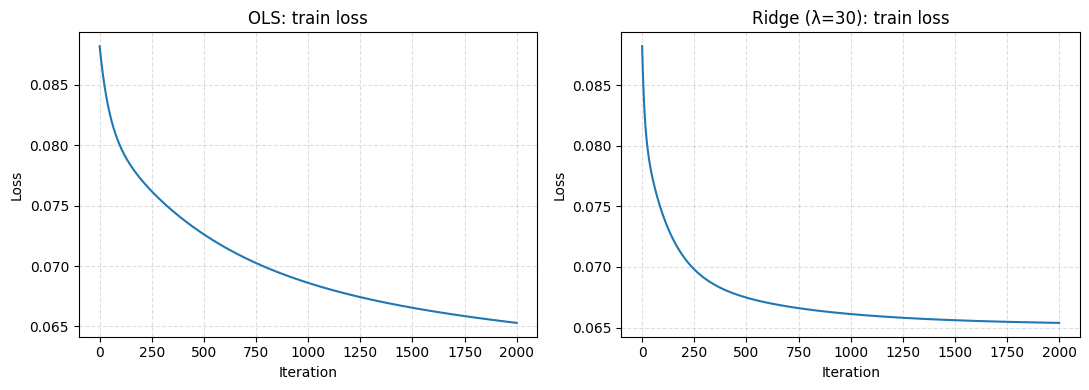

Max-stable η (auto) — OLS:   0.1024
Max-stable η (auto) — Ridge: 0.1024


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Code/grad.py:26: RuntimeWarning: overflow encountered in matmul
  return 0.5 * (r @ r) / X.shape[0]
/var/folders/yn/p45qg2hs32j6_2k0vv9s4kcw0000gn/T/ipykernel_53803/1431323541.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(losses[t+1] - losses[t]) <= 1e-8 * max(1.0, losses[t]):
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/Project-1/Code/grad.py:32: RuntimeWarning: overflow encountered in matmul
  return 0.5 * (r @ r) / n + 0.5 * alpha * (theta @ theta)


In [60]:
from Code.grad import grad_ols, grad_ridge, loss_ols, loss_ridge, alpha_from_lambda

# Gradient descent with tracing
def gd_with_trace(X, y_c, theta0, eta, iters=ITERS_FULL, lam=None, n_factor=True):
    """Same updates as your gd(), but returns (theta, losses_per_iter)."""
    theta = np.asarray(theta0, float).copy()
    losses = np.empty(iters + 1, dtype=float)
    losses[0] = loss_ols(X, y_c, theta) if lam is None else loss_ridge(X, y_c, theta, lam, n_factor)
    for t in range(iters):
        if lam is None:
            g = grad_ols(X, y_c, theta)
        else:
            g = grad_ridge(X, y_c, theta, lam, n_factor=n_factor)
        theta -= eta * g
        losses[t+1] = loss_ols(X, y_c, theta) if lam is None else loss_ridge(X, y_c, theta, lam, n_factor)
        if abs(losses[t+1] - losses[t]) <= 1e-8 * max(1.0, losses[t]):
            losses = losses[:t+2]   
            break
    return theta, losses

# --- simple stability/speed-based eta picker that uses gd_with_trace ---
def is_stable(losses, tol=1e-9):
    if np.any(~np.isfinite(losses)):
        return False
    # allow very slight increases due to fp noise; otherwise require non-increasing
    return np.all(np.diff(losses) <= tol)

# Pick eta from a grid based on stability and speed (fewest iters to within 1% of final loss)
def pick_eta_gd(Xtr, ytr_c, lam=None, n_factor=True, iters=ITERS_FULL, theta0=None, eta_grid=None):
    if eta_grid is None:
        raise ValueError("Provide eta_grid, e.g. [1e-3, 2e-3, 4e-3, 8e-3]")
    theta0 = np.zeros(Xtr.shape[1]) if theta0 is None else np.asarray(theta0, float).ravel()
    best_eta, best_speed = None, np.inf
    for eta in eta_grid:
        _, losses = gd_with_trace(Xtr, ytr_c, theta0, eta, iters, lam=lam, n_factor=n_factor)
        if not is_stable(losses): 
            continue
        final = losses[-1]
        # first iter where within 1% of final loss
        within = np.where(losses <= 1.01 * final)[0]
        if within.size == 0:
            continue
        k = int(within[0])
        if k < best_speed:
            best_speed = k
            best_eta = eta
    return best_eta

eta_grid = [ETA_FULL/4, ETA_FULL/2, ETA_FULL, 2*ETA_FULL, 4*ETA_FULL]
theta0 = np.zeros(X_tr_s.shape[1])

eta_gd_ols   = pick_eta_gd(X_tr_s, y_tr_c, lam=None, iters=ITERS_FULL, theta0=theta0, eta_grid=eta_grid)
eta_gd_ridge = pick_eta_gd(X_tr_s, y_tr_c, lam=LAM_RIDGE, n_factor=True, iters=ITERS_FULL, theta0=theta0, eta_grid=eta_grid)


print("Chosen η (GD) — OLS:", eta_gd_ols)
print("Chosen η (GD) — Ridge:", eta_gd_ridge)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(11,4))

# OLS
_, losses = gd_with_trace(X_tr_s, y_tr_c, theta0, eta_gd_ols, ITERS_FULL, lam=None)
axes[0].plot(losses); axes[0].set_title("OLS: train loss"); axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Loss"); axes[0].grid(True, ls='--', alpha=0.4)

# Ridge
_, losses = gd_with_trace(X_tr_s, y_tr_c, theta0, eta_gd_ridge, ITERS_FULL, lam=LAM_RIDGE, n_factor=True)
axes[1].plot(losses); axes[1].set_title(f"Ridge (λ={LAM_RIDGE:g}): train loss"); axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Loss"); axes[1].grid(True, ls='--', alpha=0.4)

fig.tight_layout(); plt.show()

# uses your existing helpers: gd_with_trace(...) and is_stable(...)

def find_max_stable_eta(Xtr, ytr_c, lam=None, n_factor=True,
                        eta_start=1e-3, iters=800, theta0=None, max_doubles=20):
    """
    Double η until training loss becomes unstable; return last stable η.
    """
    p = Xtr.shape[1]
    theta0 = np.zeros(p) if theta0 is None else theta0
    eta = float(eta_start)
    last_stable = None
    for _ in range(max_doubles):
        _, losses = gd_with_trace(Xtr, ytr_c, theta0, eta, iters, lam=lam, n_factor=n_factor)
        if is_stable(losses):
            last_stable = eta
            eta *= 2.0
        else:
            break
    return last_stable

# Run it separately for OLS and Ridge
eta_ols_auto   = find_max_stable_eta(X_tr_s, y_tr_c, lam=None, iters=800, eta_start=1e-4)
eta_ridge_auto = find_max_stable_eta(X_tr_s, y_tr_c, lam=LAM_RIDGE, n_factor=True, iters=800, eta_start=1e-4)

print("Max-stable η (auto) — OLS:  ", eta_ols_auto)
print("Max-stable η (auto) — Ridge:", eta_ridge_auto)



In [61]:
from Code.metrics import mse, r2
from Code.models import predict_centered
from Code.grad import gd, grad_ridge, grad_ols

# Standardized design matrix, p is number of features
p = X_tr_s.shape[1]  

# OLS via gradient descent
theta_ols = gd(X_tr_s, y_tr_c, eta=ETA_FULL_OLS, iters=ITERS_FULL, theta0=np.zeros(p), lam=None) # lam=None → OLS
yhat_te_ols = predict_centered(X_te_s, theta_ols, y_mean) # add back y_mean
mse_ols = mse(y_te, yhat_te_ols) 
r2_ols  = r2(y_te, yhat_te_ols) 

# Ridge via gradient descent (λ given)
theta_ridge = gd(X_tr_s, y_tr_c, eta=ETA_FULL_RIDGE, iters=ITERS_FULL, theta0=np.zeros(p), lam=LAM_RIDGE, n_factor=True) # lam=float → Ridge
yhat_te_ridge = predict_centered(X_te_s, theta_ridge, y_mean) # add back y_mean
mse_ridge = mse(y_te, yhat_te_ridge) 
r2_ridge  = r2(y_te, yhat_te_ridge)

print(f"OLS  — Test MSE: {mse_ols:.5f}, R²: {r2_ols:.4f}")
print(f"Ridge (λ={LAM_RIDGE}) — Test MSE: {mse_ridge:.5f}, R²: {r2_ridge:.4f}")

OLS  — Test MSE: 0.15892, R²: 0.2021
Ridge (λ=30) — Test MSE: 0.15548, R²: 0.2194


[Closed-form] OLS   MSE=0.147135  R²=0.2613
[Closed-form] Ridge MSE=0.136111  R²=0.3166


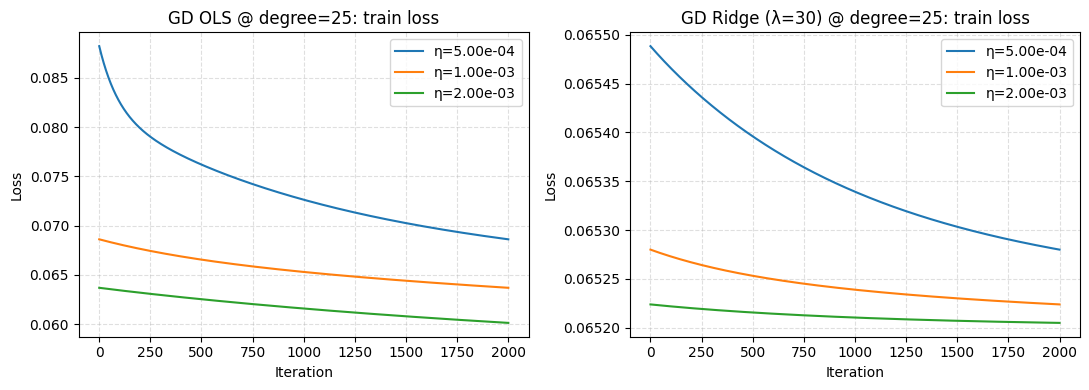

[GD best-η] OLS   MSE=0.152481  R²=0.2345
[GD best-η] Ridge MSE=0.152481  R²=0.2345
θ error OLS  (GD vs CF): 0.9999999999990238
θ error Ridge (GD vs CF): 0.9533716377081369


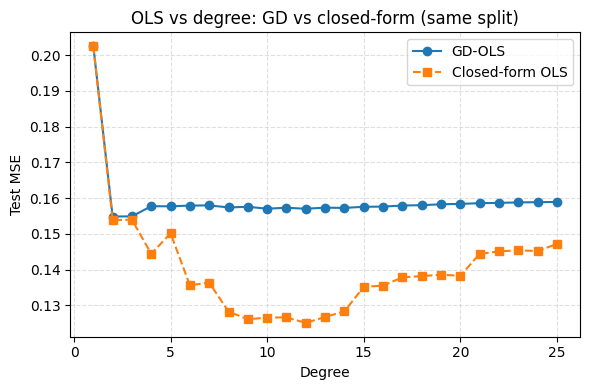

In [74]:
# --- FIX DEGREE ---
Xtr_p = X_tr_s[:, :P_FIXED]
Xte_p = X_te_s[:, :P_FIXED]
p = Xtr_p.shape[1]
theta0 = np.zeros(p)

# --- CLOSED-FORM BASELINES ---
from Code.models import fit_ols, fit_ridge, predict_centered
from Code.metrics import mse, r2

theta_cf_ols   = fit_ols(Xtr_p, y_tr_c)
theta_cf_ridge = fit_ridge(Xtr_p, y_tr_c, lam=LAM_RIDGE, n_factor=True)

yhat_cf_ols   = predict_centered(Xte_p, theta_cf_ols, y_mean)
yhat_cf_ridge = predict_centered(Xte_p, theta_cf_ridge, y_mean)

print("[Closed-form] OLS   MSE={:.6f}  R²={:.4f}".format(mse(y_te, yhat_cf_ols),   r2(y_te, yhat_cf_ols)))
print("[Closed-form] Ridge MSE={:.6f}  R²={:.4f}".format(mse(y_te, yhat_cf_ridge), r2(y_te, yhat_cf_ridge)))

# --- GD with a few learning rates and convergence plots ---

eta_list = [ETA_FULL/2, ETA_FULL, 2*ETA_FULL]  # try small, base, large
fig, axes = plt.subplots(1, 2, figsize=(11,4))

# OLS
best_eta_ols = None; best_mse_ols = np.inf
for eta in eta_list:
    th, Ls = gd(Xtr_p, y_tr_c, eta, ITERS_FULL, theta0=theta0,
                lam=None, track_loss=True, every=1)
    axes[0].plot(Ls, label=f"η={eta:.2e}")
    yhat = predict_centered(Xte_p, th, y_mean)
    m = mse(y_te, yhat)
    if m < best_mse_ols: best_mse_ols, best_eta_ols = m, eta

axes[0].set_title(f"GD OLS @ degree={P_FIXED}: train loss")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Loss"); axes[0].legend(); axes[0].grid(True, ls='--', alpha=0.4)

# Ridge
best_eta_rdg = None; best_mse_rdg = np.inf
for eta in eta_list:
    th, Ls = gd(Xtr_p, y_tr_c, eta, ITERS_FULL, theta0=theta0,
                lam=LAM_RIDGE, n_factor=True, track_loss=True, every=1)
    axes[1].plot(Ls, label=f"η={eta:.2e}")
    yhat = predict_centered(Xte_p, th, y_mean)
    m = mse(y_te, yhat)
    if m < best_mse_rdg: best_mse_rdg, best_eta_rdg = m, eta

axes[1].set_title(f"GD Ridge (λ={LAM_RIDGE}) @ degree={P_FIXED}: train loss")
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Loss"); axes[1].legend(); axes[1].grid(True, ls='--', alpha=0.4)
fig.tight_layout(); plt.show()

# --- Final comparison at the best η among those tried ---
theta_gd_ols,  _ = gd(Xtr_p, y_tr_c, best_eta_ols, ITERS_FULL, theta0=theta0, lam=None, track_loss=True)
theta_gd_ridge, _ = gd(Xtr_p, y_tr_c, best_eta_rdg, ITERS_FULL, theta0=theta0, lam=LAM_RIDGE, n_factor=True, track_loss=True)

yhat_te_ols   = predict_centered(Xte_p, theta_gd_ols,  y_mean)
yhat_te_ridge = predict_centered(Xte_p, theta_gd_ridge, y_mean)

print(f"[GD best-η] OLS   MSE={mse(y_te, yhat_te_ols):.6f}  R²={r2(y_te, yhat_te_ols):.4f}")
print(f"[GD best-η] Ridge MSE={mse(y_te, yhat_te_ridge):.6f}  R²={r2(y_te, yhat_te_ridge):.4f}")

# theta agreement (nice to show)
def rel_err(a,b): 
    den = np.linalg.norm(b) + 1e-12
    return np.linalg.norm(a-b)/den

print("θ error OLS  (GD vs CF):",   rel_err(theta_gd_ols,  theta_cf_ols))
print("θ error Ridge (GD vs CF):",  rel_err(theta_gd_ridge, theta_cf_ridge))

from Code.models  import fit_ols, predict_centered
from Code.metrics import mse

degrees = np.arange(1, DEG_MAX+1)

mse_deg_gd = []
mse_deg_cf = []

for p in degrees:
    Xtr = X_tr_s[:, :p]
    Xte = X_te_s[:, :p]

    # --- GD-OLS (fit on centered y, predict on original scale)
    theta_gd, _ = gd(Xtr, y_tr_c, ETA_FULL, ITERS_FULL,
                     theta0=np.zeros(p),
                     lam=None,             # OLS
                     track_loss=True, every=1)
    yhat_gd = predict_centered(Xte, theta_gd, y_mean)  # <-- ADD BACK y_mean
    mse_deg_gd.append(mse(y_te, yhat_gd))

    # --- Closed-form OLS for comparison (same split, same degree)
    theta_cf = fit_ols(Xtr, y_tr_c)
    yhat_cf  = predict_centered(Xte, theta_cf, y_mean)
    mse_deg_cf.append(mse(y_te, yhat_cf))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(degrees, mse_deg_gd, 'o-', label="GD-OLS")
plt.plot(degrees, mse_deg_cf, 's--', label="Closed-form OLS")
plt.xlabel("Degree"); plt.ylabel("Test MSE")
plt.title("OLS vs degree: GD vs closed-form (same split)")
plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()





In [76]:
p = 10
Xtr = X_tr_s[:, :p]; Xte = X_te_s[:, :p]
theta_gd, _ = gd(Xtr, y_tr_c, ETA_FULL, ITERS_FULL, theta0=np.zeros(p), lam=None, track_loss=True)
theta_cf    = fit_ols(Xtr, y_tr_c)

print("‖θ_GD − θ_CF‖ / ‖θ_CF‖ =", np.linalg.norm(theta_gd - theta_cf)/(np.linalg.norm(theta_cf)+1e-12))

yhat_gd = Xte @ theta_gd + y_mean
yhat_cf = Xte @ theta_cf + y_mean
print("MSE GD:", mse(y_te, yhat_gd), "  MSE CF:", mse(y_te, yhat_cf))

from Code.grad import loss_ols

p = 10
Xtr = X_tr_s[:, :p]; Xte = X_te_s[:, :p]

theta_gd, losses = gd(Xtr, y_tr_c, eta=1e-3, iters=2000,
                      theta0=np.zeros(p), lam=None, track_loss=True)

theta_cf = fit_ols(Xtr, y_tr_c)

print("Train loss  GD:", loss_ols(Xtr, y_tr_c, theta_gd))
print("Train loss  CF:", loss_ols(Xtr, y_tr_c, theta_cf))


‖θ_GD − θ_CF‖ / ‖θ_CF‖ = 0.999932335708686
MSE GD: 0.1570341492231983   MSE CF: 0.12656808392817545
Train loss  GD: 0.06573746056642546
Train loss  CF: 0.04254239952022699


In [77]:
p = 10
Xtr = X_tr_s[:, :p]; Xte = X_te_s[:, :p]
theta0 = np.zeros(p)

# Try a larger step and/or more iters
ETA_TRY   = 1e-2      # 10× larger than before
ITERS_TRY = 20000     # 10× more iterations

theta_gd, losses = gd(Xtr, y_tr_c, ETA_TRY, ITERS_TRY,
                      theta0=theta0, lam=None, track_loss=True)

theta_cf = fit_ols(Xtr, y_tr_c)

print("rel θ error:", np.linalg.norm(theta_gd - theta_cf)/(np.linalg.norm(theta_cf)+1e-12))
print("train loss GD:", loss_ols(Xtr, y_tr_c, theta_gd), "  CF:", loss_ols(Xtr, y_tr_c, theta_cf))

yhat_gd = Xte @ theta_gd + y_mean
yhat_cf = Xte @ theta_cf + y_mean
print("MSE GD:", mse(y_te, yhat_gd), "  MSE CF:", mse(y_te, yhat_cf))


rel θ error: 0.9975215631422892
train loss GD: 0.050250204285105356   CF: 0.04254239952022699
MSE GD: 0.142921101448675   MSE CF: 0.12656808392817545



## d) Optimizers: Momentum, AdaGrad, RMSProp, Adam

We keep the same objectives but change the update rule. We'll use both Ridge and OLS. 


In [63]:
# --- Optimizer (no SGD) ---
def run_optimizer(X, y, lam=LAM_RIDGE, eta=ETA_FULL, iters=ITERS_FULL, optimizer="gd",
                  beta=BETA, eps=EPS, rho=RHO, b1=B1, b2=B2, seed=SEED_DATA):
    """
    Full-batch optimizers for OLS/Ridge:
      gd        : plain gradient descent (full batch)
      momentum  : GD with momentum
      adagrad   : adaptive per-parameter steps
      rmsprop   : exponential moving avg of squared grads
      adam      : momentum + rmsprop with bias correction
    No stochastic SGD here as we'll do that later.
    """
    n, p = X.shape
    rng = np.random.default_rng(SEED_DATA)  # kept for parity; not used in full-batch
    theta = np.zeros(p, float)
    v = np.zeros_like(theta)  # momentum buffer
    s = np.zeros_like(theta)  # second-moment buffer
    m = np.zeros_like(theta)  # first-moment buffer
    t = 0

    for _ in range(ITERS_FULL):
        g = grad_ridge(X, y, theta, LAM_RIDGE) if lam is not None else grad_ols(X, y, theta)
        t += 1

        if optimizer in ("gd",):                     # plain full-batch GD
            theta -= ETA_FULL * g
        elif optimizer == "momentum":
            v = BETA * v + (1 - BETA) * g
            theta -= ETA_FULL * v
        elif optimizer == "adagrad":
            s += g * g
            theta -= (ETA_FULL / (np.sqrt(s) + EPS)) * g
        elif optimizer == "rmsprop":
            s = RHO * s + (1 - RHO) * (g * g)
            theta -= (ETA_FULL / (np.sqrt(s) + EPS)) * g
        elif optimizer == "adam":
            m = B1 * m + (1 - B1) * g
            s = B2 * s + (1 - B2) * (g * g)
            m_hat = m / (1 - B1**t)
            s_hat = s / (1 - B2**t)
            theta -= ETA_FULL * m_hat / (np.sqrt(s_hat) + EPS)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")
    return theta

# --- Run comparisons ---
opts = ["gd", "momentum", "adagrad", "rmsprop", "adam"]
results = {}

for opt in opts:
    th = run_optimizer(X_tr_s, y_tr_c, lam=LAM_RIDGE, eta=ETA_FULL, iters=ITERS_FULL, optimizer=opt)
    yhat = predict_centered(X_te_s, th, y_mean)
    results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

print(f" FULL-BATCH (RIDGE, λ={LAM_RIDGE})")

# Pretty print
for k, (mse_v, r2_v) in results.items():
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}")

for opt in opts:
    th = run_optimizer(X_tr_s, y_tr_c, lam=None, eta=ETA_FULL, iters=ITERS_FULL, optimizer=opt)
    yhat = predict_centered(X_te_s, th, y_mean)
    results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

print(" FULL-BATCH (OLS, λ=None)")

# Pretty print
for k, (mse_v, r2_v) in results.items():
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}")


 FULL-BATCH (RIDGE, λ=30)
gd        MSE=0.15967  R²=0.1984
momentum  MSE=0.15967  R²=0.1984
adagrad   MSE=0.16663  R²=0.1634
rmsprop   MSE=0.15373  R²=0.2282
adam      MSE=0.15402  R²=0.2267
 FULL-BATCH (OLS, λ=None)
gd        MSE=0.15892  R²=0.2021
momentum  MSE=0.15892  R²=0.2021
adagrad   MSE=0.16845  R²=0.1543
rmsprop   MSE=0.13959  R²=0.2992
adam      MSE=0.14355  R²=0.2793


In [64]:
# --- Optimizer with tuned eta ---
def run_optimizer(X, y, lam=None, eta=1e-3, iters=ITERS_FULL, optimizer="gd",
                  beta=BETA, eps=EPS, rho=RHO, b1=B1, b2=B2, n_factor=True):
    n, p = X.shape
    theta = np.zeros(p, float)
    v = np.zeros_like(theta)
    s = np.zeros_like(theta)
    m = np.zeros_like(theta)
    t = 0

    for _ in range(iters):
        g = grad_ols(X, y, theta) if lam is None else grad_ridge(X, y, theta, lam, n_factor=n_factor)
        t += 1 # time step

        if optimizer == "gd": 
            theta -= eta * g
        elif optimizer == "momentum":
            v = beta * v + (1 - beta) * g
            theta -= eta * v
        elif optimizer == "adagrad":
            s += g * g
            theta -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "rmsprop":
            s = rho * s + (1 - rho) * (g * g)
            theta -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "adam":    
            m = b1 * m + (1 - b1) * g
            s = b2 * s + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**t)
            s_hat = s / (1 - b2**t)
            theta -= eta * m_hat / (np.sqrt(s_hat) + eps)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}") 
    return theta

# Scaling factors for learning rates. Meaning how much to scale the base learning rate for each optimizer
scales = {"gd": 1.0, "momentum": 1.0, "adagrad": 2.0, "rmsprop": 2.0, "adam": 3.0}


opts = ["gd", "momentum", "adagrad", "rmsprop", "adam"]
results_ridge, results_ols = {}, {}

# RIDGE
for opt in opts:
    th = run_optimizer(X_tr_s, y_tr_c, lam=LAM_RIDGE,
                       eta=scales[opt]*eta_gd_ridge, iters=ITERS_FULL, optimizer=opt, n_factor=True)
    yhat = predict_centered(X_te_s, th, y_mean)
    results_ridge[opt] = (mse(y_te, yhat), r2(y_te, yhat))

# OLS
for opt in opts:
    th = run_optimizer(X_tr_s, y_tr_c, lam=None,
                       eta=scales[opt]*eta_gd_ols, iters=ITERS_FULL, optimizer=opt)
    yhat = predict_centered(X_te_s, th, y_mean)
    results_ols[opt] = (mse(y_te, yhat), r2(y_te, yhat))

# --- Run comparisons ---
opts = ["gd", "momentum", "adagrad", "rmsprop", "adam"]
results = {}

# RIDGE
for opt in opts:
    th = run_optimizer(X_tr_s, y_tr_c, lam=LAM_RIDGE, eta=ETA_FULL, iters=ITERS_FULL, optimizer=opt)
    yhat = predict_centered(X_te_s, th, y_mean)
    results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

print(f" FULL-BATCH (RIDGE, λ={LAM_RIDGE}, η={eta_gd_ridge})")

# Pretty print
for k, (mse_v, r2_v) in results.items():
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}")

# OLS
for opt in opts:
    th = run_optimizer(X_tr_s, y_tr_c, lam=None, eta=ETA_FULL, iters=ITERS_FULL, optimizer=opt)
    yhat = predict_centered(X_te_s, th, y_mean)
    results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

print(f" FULL-BATCH (OLS, λ=None, η={eta_gd_ols})")

# Pretty print
for k, (mse_v, r2_v) in results.items():
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}")

 FULL-BATCH (RIDGE, λ=30, η=0.004)
gd        MSE=0.15967  R²=0.1984
momentum  MSE=0.15967  R²=0.1984
adagrad   MSE=0.16663  R²=0.1634
rmsprop   MSE=0.15373  R²=0.2282
adam      MSE=0.15402  R²=0.2267
 FULL-BATCH (OLS, λ=None, η=0.001)
gd        MSE=0.15892  R²=0.2021
momentum  MSE=0.15892  R²=0.2021
adagrad   MSE=0.16845  R²=0.1543
rmsprop   MSE=0.13959  R²=0.2992
adam      MSE=0.14355  R²=0.2793



## e) LASSO 



In [65]:
# --- LASSO (scikit-learn) on the same split ---
from sklearn.linear_model import Lasso
from Code.metrics import mse, r2


Xtr, Xte = X_tr_s[:, :p], X_te_s[:, :p] 
mses, r2s, norms = [], [], []

# going from large -> small lambdas is faster
for lam in LAM_GRID_LASSO:
    model = Lasso(alpha=lam,
                  fit_intercept=False,    # we centered y_tr -> intercept handled by y_mean
                  max_iter=ITERS_FULL,
                  tol=1e-4,
                  random_state=SEED_DATA,
                  selection="cyclic")
    model.fit(Xtr, y_tr_c)
    theta = model.coef_.ravel()

    # add back the training mean for predictions
    yhat = Xte @ theta + y_mean

    mses.append(mse(y_te, yhat))
    r2s.append(r2(y_te, yhat))
    norms.append(float(np.linalg.norm(theta)))

mses = np.asarray(mses); r2s = np.asarray(r2s); norms = np.asarray(norms)

# Plot test MSE and R² vs λ

""" fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(lambdas, mses, 'o-', label='Test MSE')
ax1.set_xscale('log'); ax1.set_xlabel('λ'); ax1.set_ylabel('MSE (test)'); ax1.grid(True, ls='--', alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(lambdas, r2s, 's--', color='C2', label='Test R²')
ax2.set_ylabel('R² (test)')

ax1.set_title(f'LASSO vs λ (degree={p}), noise=0.3')
ax1.legend(loc='best')
plt.tight_layout(); plt.show()

# (optional) coefficient norm diagnostic
plt.figure(figsize=(8,4))
plt.plot(lambdas, norms, 'x-')
plt.xscale('log'); plt.xlabel('λ'); plt.ylabel(r'||θ||₂'); plt.grid(True, ls='--', alpha=0.4)
plt.title('LASSO coefficient size vs λ, noise=0.3, degree=15'); plt.tight_layout(); plt.show() """

best_idx = int(np.argmin(mses))
print("\nBest by MSE:")
print(f"λ* = {LAM_GRID_LASSO[best_idx]:.2e}  |  MSE* = {mses[best_idx]:.6f}  |  R²* = {r2s[best_idx]:.4f}")


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+01, tolerance: 4.234e-03
  model = cd_fast.enet_coordinate_descent(
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+01, tolerance: 4.234e-03
  model = cd_fast.enet_coordinate_descent(
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linea


Best by MSE:
λ* = 3.49e-04  |  MSE* = 0.133451  |  R²* = 0.3300


In [66]:
""" #Lasso via (sub)gradient descent with fixed learning rate """

def lasso_gd(X, y, theta, eta, lmbda, Niterations):
 
    #LASSO via plain gradient descent with fixed learning rate.

    n = X.shape[0]  # number of samples
    for iter in range(Niterations):
        # 1) OLS gradient component: (2/n) * X^T (X theta - y)
        residual = X @ theta - y
        OLS_gradient_component = (2.0 / n) * (X.T @ residual)

        # 2) L1 gradient component (subgradient): lambda * sign(theta)
        L1_gradient_component = lmbda * np.sign(theta)

        # 3) Total gradient
        total_gradient = OLS_gradient_component + L1_gradient_component

        # 4) Parameter update with fixed learning rate
        theta -= eta * total_gradient

    return theta 




In [67]:
# --- Compare LASSO: scikit vs. GD at λ=2.73e-05 (best lambda value from tests above)---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

lam = 2.73e-05  

# 1) scikit-learn Lasso 
lasso_sk = Lasso(alpha=lam, fit_intercept=False, max_iter=ITERS_FULL, tol=1e-4, random_state=SEED_DATA)
lasso_sk.fit(X_tr_s, y_tr_c)
theta_sk = lasso_sk.coef_.ravel()
yhat_sk  = X_te_s @ theta_sk + y_mean
mse_sk   = mse(y_te, yhat_sk)
r2_sk    = r2(y_te, yhat_sk)

# 2) GD Lasso at same λ
p = X_tr_s.shape[1]
theta0 = np.zeros(p)
eta = 5e-3
Niterations = ITERS_FULL  
theta_gd = lasso_gd(X_tr_s, y_tr_c, theta=theta0, eta=eta, lmbda=lam, Niterations=Niterations)
yhat_gd  = X_te_s @ theta_gd + y_mean
mse_gd   = mse(y_te, yhat_gd)
r2_gd    = r2(y_te, yhat_gd)

print(f"LASSO (scikit, λ={lam}) — Test MSE: {mse_sk:.6f}, R²: {r2_sk:.4f}")
print(f"LASSO (GD    , λ={lam}) — Test MSE: {mse_gd:.6f}, R²: {r2_gd:.4f}")

# ---------- Plot 1: overlay fitted curves on a dense grid ----------

""" xgrid = np.linspace(-1, 1, 400)
Xgrid_full = build_features(xgrid, degree=X_tr_s.shape[1], include_bias=False)  # degree = p features
Xgrid_s    = scaler.transform(Xgrid_full)[:, :p]

# True function for reference
fgrid = 1/(1+25*xgrid**2)

ygrid_sk = Xgrid_s @ theta_sk + y_mean
ygrid_gd = Xgrid_s @ theta_gd + y_mean

plt.figure(figsize=(9,5))
plt.plot(xgrid, fgrid, label='True f(x)', lw=2)
plt.plot(xgrid, ygrid_sk, label=f'LASSO scikit (λ={lam})')
plt.plot(xgrid, ygrid_gd, label=f'LASSO GD (λ={lam})', ls='--')
plt.title('LASSO fits on dense grid (degree = p)')
plt.xlabel('x'); plt.ylabel('y')
plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.tight_layout()
plt.show() """




LASSO (scikit, λ=2.73e-05) — Test MSE: 0.133605, R²: 0.3292
LASSO (GD    , λ=2.73e-05) — Test MSE: 0.151183, R²: 0.2410


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.680e+00, tolerance: 4.234e-03
  model = cd_fast.enet_coordinate_descent(


" xgrid = np.linspace(-1, 1, 400)\nXgrid_full = build_features(xgrid, degree=X_tr_s.shape[1], include_bias=False)  # degree = p features\nXgrid_s    = scaler.transform(Xgrid_full)[:, :p]\n\n# True function for reference\nfgrid = 1/(1+25*xgrid**2)\n\nygrid_sk = Xgrid_s @ theta_sk + y_mean\nygrid_gd = Xgrid_s @ theta_gd + y_mean\n\nplt.figure(figsize=(9,5))\nplt.plot(xgrid, fgrid, label='True f(x)', lw=2)\nplt.plot(xgrid, ygrid_sk, label=f'LASSO scikit (λ={lam})')\nplt.plot(xgrid, ygrid_gd, label=f'LASSO GD (λ={lam})', ls='--')\nplt.title('LASSO fits on dense grid (degree = p)')\nplt.xlabel('x'); plt.ylabel('y')\nplt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.tight_layout()\nplt.show() "

In [ ]:
from Code.models import fit_lasso_skl
from Code.grad import lasso_gd, lasso_ista

# ---------- Make a validation split from the *training* set ----------
rng = np.random.default_rng(42)
n_tr = Xtr_p.shape[0]
perm = rng.permutation(n_tr)
val_frac = 0.2
n_val = int(round(val_frac * n_tr))
val_idx = perm[:n_val]
tr_idx  = perm[n_val:]

X_tr, y_tr = Xtr_p[tr_idx], y_tr_c[tr_idx]
X_val, y_val = Xtr_p[val_idx], y_tr_c[val_idx]

# ---------- Step size from data (no tuning) ----------
# L = (2/n) * sigma_max(X_tr)^2
smax = np.linalg.svd(X_tr, compute_uv=False)[0]
L = (2.0 / X_tr.shape[0]) * (smax**2)
eta_ista = 1.0 / L

# ---------- 4) λ grid : from λ_max downwards ----------
# λ_max = (2/n) * ||X^T y||_∞  makes θ=0 optimal
lam_max = (2.0 / X_tr.shape[0]) * np.max(np.abs(X_tr.T @ y_tr))
lam_min = lam_max * 1e-3
lam_grid = np.geomspace(lam_max, lam_min, 60)

# ---------- 5) Sweep λ on validation (warm starts) ----------
best_lam, best_val = None, np.inf
theta_ws = np.zeros(X_tr.shape[1])   # warm start across lambdas (from large→small)
for lam in lam_grid:
    # define validation loss for early stopping:
    def val_loss(th):
        yhat_val = X_val @ th + y_mean  # add back mean for metric on original scale
        return mse(y[val_idx], yhat_val)

    theta_ws = lasso_ista(X_tr, y_tr, lam=lam, eta=eta_ista,
                          iters=5000, theta0=theta_ws, early_stop=val_loss)

    # final validation MSE for this λ
    yhat_val = X_val @ theta_ws + y_mean
    val_m = mse(y[val_idx], yhat_val)

    if val_m < best_val:
        best_val = val_m
        best_lam = lam
        best_theta_val = theta_ws.copy()

print(f"Chosen λ (hold-out): {best_lam:.3e}  with val MSE={best_val:.6f}")

# ---------- 6) Refit on full training with λ* ----------
# (optional warm start from the validation solution)
theta_star = lasso_ista(Xtr_p, y_tr_c, lam=best_lam, eta=eta_ista,
                        iters=8000, theta0=best_theta_val, early_stop=None)

# ---------- 7) Test metrics ----------
yhat_te = Xte_p @ theta_star + y_mean
print("Lasso (hold-out λ*)  Test MSE/R²:", mse(y_te, yhat_te), r2(y_te, yhat_te))

# (Optional) Compare to scikit-learn, remembering alpha = λ/2 to match your scaling:
# from sklearn.linear_model import Lasso
# alpha = best_lam / 2.0
# skl = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000, tol=1e-6, selection="cyclic").fit(Xtr_p, y_tr_c)
# yhat_skl = Xte_p @ skl.coef_.ravel() + y_



## f) Stochastic Gradient Descent



In [68]:
def sgd_minibatch_sum(
    X, y, lam=LAM_RIDGE, epochs=EPOCHS_MB, batch_size=BATCH_SIZE, eta=ETA_FULL, optimizer="sgd",
    beta=BETA, eps=EPS, rho=RHO, b1=B1, b2=B2, seed=SEED_DATA
):
    """
    Mini-batch SGD (sum form) for OLS/Ridge with per-sample loss:
        c_i(θ) = 1/2 (x_i^T θ - y_i)^2 + (lam/2) ||θ||^2
    Batch gradient (sum form):
        G_B = X_B^T (X_B θ - y_B) + lam * |B| * θ
    Update:
        θ <- θ - η * G_B
    """
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p, float)

    # state buffers (for momentum/Adagrad/RMSProp/Adam)
    v = np.zeros_like(theta)
    s = np.zeros_like(theta)
    m = np.zeros_like(theta)
    t = 0

    for _ in range(epochs):
        idx = rng.permutation(n) # shuffle data each epoch
        for start in range(0, n, batch_size):
            B = idx[start:start+batch_size] # batch indices
            Xb, yb = X[B], y[B]
            nb = Xb.shape[0]

            r = Xb @ theta - yb                            # residuals
            g = (Xb.T @ r) + lam * nb * theta              # SUM-FORM gradient

            t += 1
            if optimizer == "sgd":
                theta -= eta * g
            elif optimizer == "momentum":
                v = beta * v + (1 - beta) * g
                theta -= eta * v
            elif optimizer == "adagrad":
                s += g * g
                theta -= (eta / (np.sqrt(s) + eps)) * g
            elif optimizer == "rmsprop":
                s = rho * s + (1 - rho) * (g * g)
                theta -= (eta / (np.sqrt(s) + eps)) * g
            elif optimizer == "adam":
                m = b1 * m + (1 - b1) * g
                s = b2 * s + (1 - b2) * (g * g)
                m_hat = m / (1 - b1**t)
                s_hat = s / (1 - b2**t)
                theta -= eta * m_hat / (np.sqrt(s_hat) + eps)
            else:
                raise ValueError("Unknown optimizer")
    return theta


lam_val = LAM_RIDGE
B0, eta0 = 64, ETA_FULL
B = 128
eta = eta0 * (B0 / B)  # scale eta for sum-form
epochs = int(1.5 * 25)

# full-batch (e.g., Adam)
theta_full = run_optimizer(X_tr_s, y_tr_c, lam=lam_val, eta=eta0, iters=5000, optimizer="adam")

# stochastic (sum form), same optimizer rule
theta_sgd  = sgd_minibatch_sum(X_tr_s, y_tr_c, lam=lam_val, epochs=epochs, batch_size=B, eta=eta, optimizer="adam", seed=42)

yhat_full = predict_centered(X_te_s, theta_full, y_mean)
yhat_sgd  = predict_centered(X_te_s, theta_sgd,  y_mean)

print(f"Full-batch Adam (λ={lam_val}):  MSE={mse(y_te,yhat_full):.6f}, R²={r2(y_te,yhat_full):.4f}")
print(f"SGD (sum form) Adam (λ={lam_val}, B={64}):  MSE={mse(y_te,yhat_sgd):.6f}, R²={r2(y_te,yhat_sgd):.4f}")


Full-batch Adam (λ=30):  MSE=0.154019, R²=0.2267
SGD (sum form) Adam (λ=30, B=64):  MSE=0.194069, R²=0.0257


In [69]:
def sgd_minibatch(
    X, y, lam=1e-3, epochs=40, batch_size=64, eta=1e-2, optimizer="sgd",
    beta=0.9, eps=1e-8, rho=0.99, b1=0.9, b2=0.999, seed=42
):
    """
    Part f) Mini-batch SGD framework using the SAME update rules as parts c–e.
    Matches the 1/(2n) loss convention: grad = (1/nb) X_b^T (X_b θ - y_b) + lam * θ
    Supports: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
    """
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p, float)

    # state buffers (shared across optimizers)
    v = np.zeros_like(theta)  # momentum
    s = np.zeros_like(theta)  # second moment (AdaGrad/RMSProp/Adam)
    m = np.zeros_like(theta)  # first moment (Adam)
    t = 0

    for _ in range(epochs):
        idx = rng.permutation(n)
        for start in range(0, n, batch_size):
            b = idx[start:start+batch_size]
            Xb, yb = X[b], y[b]
            nb = Xb.shape[0]

            # gradient for ridge MSE with 1/(2n) convention
            r = Xb @ theta - yb
            g = (Xb.T @ r) / nb + lam * theta

            t += 1
            if optimizer == "sgd":
                theta -= eta * g

            elif optimizer == "momentum":
                v = beta * v + (1 - beta) * g
                theta -= eta * v

            elif optimizer == "adagrad":
                s += g * g
                theta -= (eta / (np.sqrt(s) + eps)) * g

            elif optimizer == "rmsprop":
                s = rho * s + (1 - rho) * (g * g)
                theta -= (eta / (np.sqrt(s) + eps)) * g

            elif optimizer == "adam":
                m = b1 * m + (1 - b1) * g
                s = b2 * s + (1 - b2) * (g * g)
                m_hat = m / (1 - b1**t)
                s_hat = s / (1 - b2**t)
                theta -= eta * m_hat / (np.sqrt(s_hat) + eps)

            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

    return theta

theta_full = run_optimizer(X_tr_s, y_tr_c, lam=2.73e-05, eta=5e-3, iters=5000, optimizer="adam")
theta_sgd  = sgd_minibatch(X_tr_s, y_tr_c, lam=2.73e-05, epochs=25, batch_size=64, eta=5e-3, optimizer="adam")

yhat_full = predict_centered(X_te_s, theta_full, y_mean)
yhat_sgd  = predict_centered(X_te_s, theta_sgd,  y_mean)
print("Full-batch Adam:", mse(y_te, yhat_full), r2(y_te, yhat_full))
print("Mini-batch Adam:", mse(y_te, yhat_sgd),  r2(y_te, yhat_sgd))


Full-batch Adam: 0.13462049361074663 0.32413198145431465
Mini-batch Adam: 0.15587290566992335 0.21743332627566858
